# A web service of time series of Earth observation data

## Context: The E-SENSING project

The e-sensing project is about developing new ways to extract information on land use and land cover change from big Earth Observation data sets. We address the following scientific question: 

***How can we use e-science methods and techniques to improve the extraction of land use and land cover change information from big Earth Observation data sets in an open and reproducible way?*** 

To answer this, our project is building a new generation of knowledge platform for handling big geospatial data. We're conceiving, building, and deploying a new type of knowledge platform for accessing, processing and analyzing big Earth Observation data.

We assume that decades of satellite images can be effectively organized into a data structure which can be efficiently queried and processed using the array data model. 

<img src="img/datacube.png" alt="A data cube of satellite images is as an array" title="data cube" height="300" width="400" />

Our approach is to put data and analysis together to help scientists to do larger, longer, and faster research on land use and land cover change.

<img src="img/architecture.png" alt="e-sensing project's architecture " title="e-sensing architecture" height="300" width="400" />

The "e-sensing" project is supported by __[FAPESP](http://bv.fapesp.br/pt/auxilios/89598/e-sensing-analise-de-grandes-volumes-de-dados-de-observacao-da-terra-para-informacao-de-mudancas-de/)__, under the  __[e-science program](http://www.fapesp.br/8436)__ .

For additional information, please visits us at:

- our  __[official page](http://esensing.org/)__ 
- our code at __[github](https://github.com/e-sensing/)__
- our project at __[research gate](https://www.researchgate.net/project/e-sensing-big-earth-observation-data-analytics-for-land-use-and-land-cover-change-information-wwwesensingorg)__


## The Web Time Series Service

The Web Time Series Service (WTSS) is a lightweight web service for handling time series data from remote sensing imagery. It exposes 3 operations:
- *list_coverages*: get the list of available coverages.
- *describe_coverage*: get metadata about a specific coverage.
- *time_series*: get a time series for a given location and time interval.

WTSS is developed and maintained by the National Institute for Space Research of Brazil __[INPE](http://www.inpe.br/)__, where we have a WTSS instance running. For additional details such as the source code and the WTSS clients for Python, R, and Javascript go to the __[WTSS repository](https://github.com/e-sensing/tws/tree/master/src/tws/wtss)__. If you are interested on setting your own WTSS, you can contact us through the __[e-sensing](http://esensing.org/)__ links provided above.

In [35]:
%matplotlib inline
# configuration

#import pip
#def install(package):
#   pip.main(['install', package])
#install('wtss')
#install('pandas')
#install('numpy')
#install('scipy')

import numpy as np
import scipy as sp
import pandas as pd
import math
import matplotlib
from scipy import stats
from wtss import wtss

matplotlib.style.use('ggplot')

## WTSS for python

The __[python client](https://github.com/e-sensing/wtss.py)__ for WTSS enables users to retrieve time series of Earth observation data for specific locations. Using a few lines of code, you can retrieve data from Earth observation.

**WTSS** easily integrates with Python analysis libraries such as __[numpy](http://www.numpy.org/)__, __[scipy](https://www.scipy.org/)__, and __[pandas](http://pandas.pydata.org/)__.

### WTSS: List coverages

This operation gets a list of the data sets hosted in the WTSS. In the example below, we create a WTSS object and we query and print its contents.

In [36]:
# WTSS python client: Access to data & metadata
w = wtss("http://www.dpi.inpe.br/tws")

# print the available data sets
cv_list = w.list_coverages()
for cv_name in cv_list["coverages"]:
    print(cv_name)

itobi
merge
mixl8mod
mixl8mod_f
mod13q1_512


### WTSS: Describe coverage

This operations enables users to explore the details of a data sets in the WTSS. Below, we ask WTSS for the details of a coverage. Then we format and print the WTSS's reponse.

In [37]:
# explore a WTSS data set
cv_scheme = w.describe_coverage("mod13q1_512")
# format response
print("ARRAY mod13q1_512")
print("\nSPATIAL REFERENCE SYSTEM:\n" + str(cv_scheme['crs']))
print("\nDIMENSIONS:\n" + str(cv_scheme['dimensions']))
print("\nTIMELINE:\nFirst five:" + str(cv_scheme['timeline'][0:5]) + "...\nLast  five: ..." + str(cv_scheme['timeline'][-5:]))
print("\nDESCRIPTION:\n" + str(cv_scheme['description']) + " - " + str(cv_scheme['detail']))

print("\nATTRIBUTES:")
for att in cv_scheme['attributes']:
    print(str(att['name']) + ": " + str(att['description']) + ". Type: " + str(att['datatype']))

ARRAY mod13q1_512

SPATIAL REFERENCE SYSTEM:
{u'proj4': u'+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', u'wkt': u'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'}

DIMENSIONS:
{u'y': {u'max_idx': 86399, u'min_idx': 0, u'name': u'row_id'}, u'x': {u'max_idx': 172799, u'min_idx': 0, u'name': u'col_id'}, u't': {u'max_idx': 376, u'min_idx': 0, u'name': u'time_id'}}

TIMELINE:
First five:[u'2000-02-18', u'2000-03-05', u'2000-03-21', u'2000-04-06', u'2000-04-22']...
Last  five: ...[u'2016-12-18', u'2017-01-01', u'2017-01-17', u'2017-02-02', u'2017-02-18']

DESCRIPTION:
Vegetation Indices 16-Day L3 Global 250m - https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1

ATTRIBUTES:
ndvi: 250m 16 days NDVI. Type: int16
evi: 250m 16 days EVI. Type: int16
red: 250m 

### WTSS: Time series

This operation retrieves a time series of the provided point. Here, we ask WTSS for some vegetation indexes, then we create *pandas* series out of them, and finally we put the series together into a *pandas* data frame.

In [38]:
# get time series of a point
ts = w.time_series("mod13q1_512", ("ndvi", "evi"), -12.0, -54.0)

# build a data frame made of vegetation indexes
ndvi = pd.Series(ts["ndvi"], index = cv_scheme["timeline"])/10000
evi  = pd.Series(ts["evi"],  index = cv_scheme["timeline"])/10000

vidf = pd.DataFrame({'ndvi': ndvi, 'evi': evi})
vidf[0:5]

,evi,ndvi
2000-02-18,0.3227,0.5532
2000-03-05,0.3328,0.4512
2000-03-21,0.5831,0.8734
2000-04-06,0.4962,0.8865
2000-04-22,0.5341,0.8859


## WTSS and Python Data Analysis Library (pandas)

### Data visualization

Python provides tools for scientific data visualization. Below, we take advantage of the integration between *pandas* and *matplotlib* in order to plot our vegetation indexes.

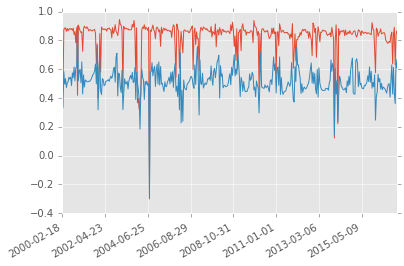

In [39]:
# Time series visualization
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['evi'].plot()
fig.autofmt_xdate()

### Line fitting

A simple way to reveal coarse trends in time series is to adjust a straight line through the data. In the code below, we have a function to fit lines which we use in our time series. Then we plot the vegetation indexes along the adjusted lines.

,evi,ndvi,ndvi_lm,evi_lm
2000-02-18,0.3227,0.5532,0.823311,0.530569
2000-03-05,0.3328,0.4512,0.823337,0.530492
2000-03-21,0.5831,0.8734,0.823364,0.530415
2000-04-06,0.4962,0.8865,0.823391,0.530339
2000-04-22,0.5341,0.8859,0.823417,0.530262


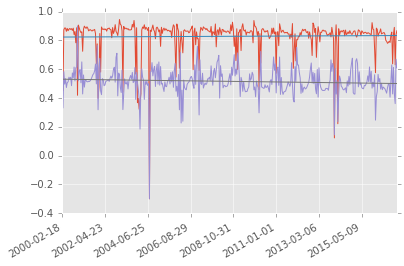

In [40]:
# fit a line to a time series
def fitline(vi):
    """!
    Fit a line to a time series.
    @param vi pandas.Series: A time series
    @return   Return a numpy.ndarray with the values of the fitted line for each element in vi.
    """
    vi = pd.Series(vi.values, index = range(len(vi.values)))                       # re-build the series
    obid = pd.Series(range(len(vi.values)), index = range(len(vi.values)))         # add an index to the series
    sl, it, r, p, sde = stats.linregress(x = range(len(vi.values)), y = vi.values) # fit the line
    lmdf = pd.DataFrame({'obid': obid, 'vi': vi})                                  # build a data frame
    lmdf['vi_lm'] = lmdf['obid'] * sl + it                                          # compute the line's points
    return(lmdf['vi_lm'].values)

# fit a line to the vegetation indexes
vidf['ndvi_lm'] = fitline(vidf['ndvi'])
vidf['evi_lm'] = fitline(vidf['evi'])

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['ndvi_lm'].plot()
vidf['evi'].plot()
vidf['evi_lm'].plot()
fig.autofmt_xdate()
vidf[0:5]

### Fourier decomposition

Fourier series analysis allow us to decompose time series into a sum of waves represented by periodic functions. These functions have properties such as amplitude, wavelength, and frequency. In time series analysis, it is accepted that high frequencies are associated with noise. Therefore, in order to diminish noise we need to remove high frequencies from our time series. 

In the example below, the Fourier filter function removes any trend in the data by fitting a line, then it computes the Fast Fourier Transform (FFT), then it removes the frequencies higher than a given threshold, and finally computes the Inverse FFT to re-build a smoother time series.

,evi,ndvi,ndvi_lm,evi_lm,ndvi_ff,evi_ff,ndvi_kf,evi_kf
2000-02-18,0.3227,0.5532,0.823311,0.530569,0.791676,0.507752,0.828515,0.515611
2000-03-05,0.3328,0.4512,0.823337,0.530492,0.792255,0.508760,0.622029,0.370928
2000-03-21,0.5831,0.8734,0.823364,0.530415,0.793921,0.511802,0.548816,0.354587
2000-04-06,0.4962,0.8865,0.823391,0.530339,0.796626,0.516467,0.646192,0.423141
2000-04-22,0.5341,0.8859,0.823417,0.530262,0.800278,0.522038,0.701647,0.440001


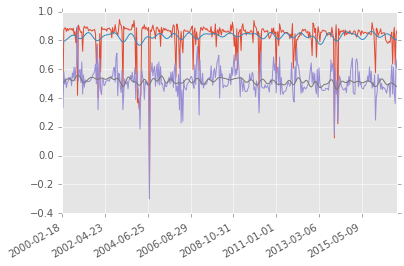

In [44]:
# Fourier decomposition
def fourierfilter(vi, fq_keep):
    """!
    Filter a time series using Fourier decomposition.
    @param vi      pandas.Series: A time series
    @param fq_keep int: The number of low frequencies to keep
    @return        Return a numpy.ndarray with filtered values for each element in vi.
    """
    vi = pd.Series(vi.values, index = range(len(vi.values)))               # re-build the series
    fdf = pd.DataFrame({'vi': vi})
    ## de-trend the time series by fitting a trend line
    fdf['vi_lm'] = fitline(fdf['vi'])
    fdf['residual'] = fdf['vi'] - fdf['vi_lm']
    # compute the discrete Fourier Transform
    vi_fft = np.fft.fft(fdf['residual'].values).real
    # remove the frequencies from index fq_keep to the last one
    vi_fft[fq_keep:] = 0
    # compute the inverse discrete Fourier Transform
    vi_ifft = np.fft.ifft(vi_fft).real
    # add the residuals back
    return(vi_ifft + fdf['vi_lm'].values)

# filter the vi
vidf['ndvi_ff'] = fourierfilter(vidf['ndvi'], 25)
vidf['evi_ff'] = fourierfilter(vidf['evi'], 45)

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['ndvi_ff'].plot()
vidf['evi'].plot()
vidf['evi_ff'].plot()
fig.autofmt_xdate()
vidf[0:5]

### Kalman filter

The Kalman filter aims to separate time series from noise. It is an iterative algorithm on which the outputs of one iteration are the inputs for the next one. In this way, the filter successively improves its estimations of the true value of a time series. 

In the example below, we estimate the initial parameters for the filter from the time series itself. Then we compute the Kalman filter and plot the smoothed vegetation indexes.

,evi,ndvi,ndvi_lm,evi_lm,ndvi_ff,evi_ff,ndvi_kf,evi_kf
2000-02-18,0.3227,0.5532,0.823311,0.530569,0.791676,0.507752,0.828515,0.515611
2000-03-05,0.3328,0.4512,0.823337,0.530492,0.792255,0.508760,0.622029,0.370928
2000-03-21,0.5831,0.8734,0.823364,0.530415,0.793921,0.511802,0.548816,0.354587
2000-04-06,0.4962,0.8865,0.823391,0.530339,0.796626,0.516467,0.646192,0.423141
2000-04-22,0.5341,0.8859,0.823417,0.530262,0.800278,0.522038,0.701647,0.440001


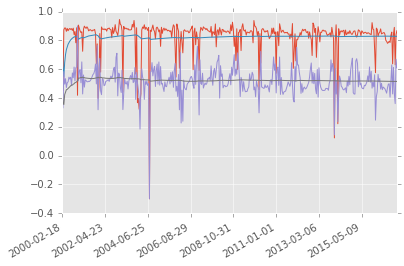

In [42]:
# Kalman filter
def kalmanfilter(vi, e_mea = None, est_0 = None, e_est_0 = None):
    """!
    Filter a time series using the Kalman filter.
    @param vi      pandas.Series: A time series made of measurements
    @param e_mea   int: The error in the measurements
    @param est_0   int: The estimate of the first measurement
    @param e_est_0 int: The initial error in the estimate
    @return        Return a numpy.ndarray with filtered values for each element in vi.
    """
    est   = np.zeros(len(vi)) # estimation
    e_est = np.zeros(len(vi)) # error in estimation
    kg    = np.zeros(len(vi)) # Kalman gain
    # deal with missing values
    if est_0 is None:
        est[0]   = vi.mean()
    else:
        est[0]   = est_0
    if e_mea is None:
        e_mea = vi.std()
    if e_est_0 is None:
        e_est[0] = 3 * vi.std()
    else:
        e_est[0] = e_est_0
    # do the filtering
    kg[0]    = None
    for i in range(1, len(vi)):
        kg[i] = e_est[i - 1]/(e_est[i - 1] + e_mea)    # compute the Kalman gain
        m = vi[i - 1]
        if(np.isnan(m)):
            m = est[i - 1]                             # use the estimation when a measurement is missing
        est[i] = est[i - 1] + kg[i] * (m - est[i - 1]) # compute the new estimation
        e_est[i] = (1 - kg[i]) * e_est[i - 1]
    return est

# filter the vi
vidf['ndvi_kf'] = pd.Series(kalmanfilter(ndvi), index = cv_scheme["timeline"])
vidf['evi_kf']  = pd.Series(kalmanfilter(evi), index = cv_scheme["timeline"])

# plot
fig, ax = matplotlib.pyplot.subplots()
ax.plot()
vidf['ndvi'].plot()
vidf['ndvi_kf'].plot()
vidf['evi'].plot()
vidf['evi_kf'].plot()
fig.autofmt_xdate()
vidf[0:5]

### TODO: Dynamic Time Warping

In [43]:
# DTW & TWDTW
# TODO:

## Final remarks

We introduced the Web Time Series Service (WTSS), a light weight Web Service of time series of Earth observation data. Through examples and code, we show how the WTSS is used and integrated with Python's scientific libraries such as NumPy, SciPy and Pandas. We demonstrated how WTSS fits into the analytic work flow of Earth Observation Scientists by using it to obtain and filter data.

What are the constraints of WTSS?
- So far, our WTSS implementation only provides data from MODIS __[MOD13Q1](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13q1)__
- The WTSS interface is still simple, we need to extend the service in order to serve complex applications

What is missing?
- Today, in terms of Map Algebra, WTSS enables local operations. We need to extend it to focal, zonal and global operations.
- WTSS is about time series analysis. But we still need to see cubes of satellite data as images. In other words, we need the equivalent of Web Mapping Server, Web Feature Service, and Web Coverage Server for big Earth observation data.
- Our Array database cluster (SciDB) is slow for retrieving images and it does not have native support for the spatio-temporal metadata associated with Earth observation imagery

Finally, we would like to invite you to explore some results of the **e-sensing** project by clicking __[here](http://terrabrasilis.info/composer/E-SENSING)__. We are working on new features of WTSS and also a new Web Service for processing large amounts of Earth observation data.